In [1]:
import json
import math
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# I. Load the data & some insights

In [2]:
# We load the 3 datasets 
df_business = pd.read_csv('./data/df_business.csv')
df_reviews = pd.read_csv('./data/df_reviews.csv')
df_users = pd.read_csv('./data/df_user.csv')

In [3]:
# Convert the string of friends to a list
df_users['friend_list'] = df_users.apply(lambda x: x.friends.split(', '), axis=1)
df_user = df_users.drop('friends', axis=1)

For reading purposes, the 3 datasets have the following form.

In [4]:
df_business.head(3)

,business_id,state,latitude,longitude,stars
0,f9NumwFMBDn751xgFiRbNA,NC,35.462724,-80.852612,3.5
1,Yzvjg0SayhoZgCljUJRF9Q,AZ,33.569404,-111.890264,5.0
2,XNoUzKckATkOD1hP6vghZg,QC,45.479984,-73.580070,5.0


In [5]:
df_reviews.head(3)

,review_id,user_id,business_id,stars,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,2015-12-05 03:18:11


In [6]:
df_users.head(3)

,user_id,friends,friend_list
0,ntlvfPzc8eglqvk92iDIAw,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...","[oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfD..."
1,FOBRPlBHa3WPHFB5qYDlVg,"ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...","[ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOu..."
2,zZUnPeh2hEp0WydbAZEOOg,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...","[Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnP..."


In [7]:
print('There are', df_business.shape[0], 'businesses')
print('There are', df_reviews.shape[0], 'reviews')
print('There are', df_users.shape[0], 'users')

There are 209393 businesses
There are 8021122 reviews
There are 1968703 users


For our study, we need to infer user's home, so we need **at least 3 reviews**. Also, we will study users with **at least 3 friends**.  

In [9]:
# We count the number of reviewe per user
df_numberOfReviews = df_reviews.groupby('user_id').count().drop(['business_id', 'stars', 'date'], axis = 1).rename(columns={'review_id': 'review_count'})
df_numberOfReviews.head()

,review_count
user_id,
---1lKK3aKOuomHnwAkAow,131
---3o4ZsKYoBYBe7H6xG8A,1
---89pEy_h9PvHwcHNbpyg,1
---94vtJ_5o_nikEs6hUjg,5
---PLwSf5gKdIoVnyRHgBA,3


In [10]:
# We merge the df_users dataset to the df_numberOfReviews dataset
df_users = pd.merge(df_users, df_numberOfReviews, left_on='user_id', right_on='user_id', how='inner')

In [11]:
# We create a mask for users with more than 3 friends
mask = df_users.apply(lambda x: len(x.friend_list) >= 3, axis=1)

In [12]:
print('Number of users with more than 3 reviews:', df_numberOfReviews[df_numberOfReviews['review_count'] >= 3].shape[0])
print('Number of users with more than 3 friends:', df_users[mask].shape[0])

Number of users with more than 3 reviews: 602736
Number of users with more than 3 friends: 957463


In [13]:
# Select users that satisfy both conditions
df_selectedUsers = df_users[mask&(df_users['review_count'] >= 3)]
print('Number of users with more than 4 reviews and with more than 3 friends:', df_selectedUsers.shape[0])

Number of users with more than 4 reviews and with more than 3 friends: 343424


In [69]:
friends_dict = df_selectedUsers.set_index("user_id")["friend_list"].to_dict()

In [14]:
# Number of checkins of the selected users
print('Number of checkins of selected users:', df_selectedUsers['review_count'].sum())

Number of checkins of selected users: 4516345


In [15]:
# Merge review and business dataframe
df_reviews = pd.merge(df_reviews, df_business, left_on='business_id', right_on='business_id', how='inner').drop(['state'], axis=1)

In [17]:
# Select only rows of selected users
df_selectedReviews = df_reviews[df_reviews["user_id"].isin(df_selectedUsers.user_id)]

In [57]:
# Convert date to datetime object
df_selectedReviews["date"] = pd.to_datetime(df_selectedReviews.date.values)

<ipython-input-57-f1ff465342bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selectedReviews["date"] = pd.to_datetime(df_selectedReviews.date.values)


In [204]:
df_selectedReviews

,review_id,user_id,business_id,stars_x,date,latitude,longitude,stars_y
1,t7xOZF5UKXjSpVcXLOSAgw,owbC7FP8SNAlwv6f9S5Stw,-MhfebM0QIsKt87iDN-FNw,2,2014-03-14 08:24:25,36.112896,-115.177637,3.5
2,MimB5Xh85rG7phUMPrShag,v9vGnjphb0Hta0lvtf5haA,-MhfebM0QIsKt87iDN-FNw,3,2015-10-07 22:16:59,36.112896,-115.177637,3.5
4,cnV5xtm6WuyaLfot9uWbDg,LkWNo83Lg92C5V4JEyxOZA,-MhfebM0QIsKt87iDN-FNw,3,2010-10-10 01:27:31,36.112896,-115.177637,3.5
5,i593z2rGxk5Lj23Bx9o1Lg,mLtaUzSjIFO_3BmfPNUKqg,-MhfebM0QIsKt87iDN-FNw,1,2015-08-20 01:10:53,36.112896,-115.177637,3.5
6,TWpbq_vbpJRotCQ6l8SeXA,wKX1tAeRIYPU4NtM-R5N2w,-MhfebM0QIsKt87iDN-FNw,5,2012-03-31 22:00:15,36.112896,-115.177637,3.5
...,...,...,...,...,...,...,...,...
8021103,aoc4p8TMwZPGArkWJwp_3A,MqeC_AaJ2sUp9F0xfm-kZw,p4yQ3QJbRTwjUS3dxP23EA,5,2019-06-17 19:44:32,33.678238,-112.101291,5.0
8021107,kPB6u7yU0p04jsaTM2kg4g,p0ndG4QEa0D502O9D07hmA,zf2-GEQ32-tN-sxUn3Te6A,5,2019-12-11 21:40:24,35.988448,-115.091844,5.0
8021109,SuwjID5CulwUpQrrpieaGA,PcfjPDJjlAbFTHyxDys8YA,zf2-GEQ32-tN-sxUn3Te6A,5,2019-07-24 01:50:00,35.988448,-115.091844,5.0
8021110,hLbvNMY8XLSs3r6NhxXapg,4xG1aexd2byltBd4rr-puw,_wEWbwthVLxc0fefm8Kqpg,5,2016-01-16 23:40:10,33.559234,-112.326905,5.0


# Getting the Reviewed Label

In [33]:
df_reviews["date"] = pd.to_datetime(df_reviews.date.values)

In [47]:
df_reviews = df_reviews.rename({"stars_x" : "rating", "stars_y" : "average_rating"},axis=1)

In [49]:
df_reviews_groupedUser = df_reviews.groupby(["user_id","business_id"])[["date","rating"]].agg(list)

In [139]:
df_reviews_groupedUser

date rating
user_id                business_id                                         
---1lKK3aKOuomHnwAkAow --9e1ONYQuAa-CB_Rrw7Tw  [2008-11-11 04:40:05]    [4]
                       -ErwgUmZ1-jHW_rSu55jlg  [2010-11-09 20:21:52]    [5]
                       0YhT9HCBkU394IG6tQVtNQ  [2012-05-01 16:17:54]    [1]
                       1JgaRBX0oiRsvEhHF3ZMjw  [2011-02-16 03:58:48]    [1]
                       1Vn_lex3LGGwuTo-xeJnww  [2011-02-16 04:16:12]    [5]
...                                                              ...    ...
zzzfcCWPDkg-kGVpqCKCEg WcHTXumqKMt0WdF-9RWljw  [2015-01-19 04:43:56]    [5]
zzzhFxwfzL56CQVnw8piTw wHwHmozyqtIE5U3uTtvpuA  [2016-06-20 19:29:23]    [5]
zzzmshdEWLFCApxETl1TGQ 74pWjFssgqyhaVg-YCUo3A  [2013-01-05 15:16:10]    [5]
                       WivFagb6JtTeJskEEvYfXg  [2017-01-31 16:00:51]    [5]
zzzv9W8ShM4TkXZGMFVY1w 6WU_JVpPPnbAfBvMcRoPuw  [2019-08-20 16:55:44]    [5]

[7735091 rows x 2 columns]

In [142]:
level_user_id = df_reviews_groupedUser.groupby(level='user_id')

In [156]:
user_business_date_dict = {}

for idx, data in level_user_id:
    user_business_date_dict[idx] = {}
    for row_index, row in data.iterrows():
        user_business_date_dict[idx][row_index[1]] = (row.date,row.rating)

In [188]:
user_business_date_dict.get('---1lKK3aKOuomHnwAkAow', {}).get('1JgaRBX0oiRsvEhHF3ZMjw')

([Timestamp('2011-02-16 03:58:48')], [1])

In [193]:
#takes a row of the shape ["user_id","business_id","date"]
#returns a label : if a friend has left a good review in the same place before : 2, if a friend has left a bad review
#in the same place before : 1, and if a friend hasn't left a review before : 0.
def get_visit_label(user_id,business_id,date_user):
    #get friend list of user:
    friends = friends_dict.get(user_id)
    for friend_id in friends:
        friend_dates_rating = user_business_date_dict.get(friend_id, {}).get(business_id)
        if(friend_dates_rating != None):
            for date,rating in zip(friend_dates_rating[0],friend_dates_rating[1]):
                if(date < date_user):
                    return rating
    return -1

In [190]:
selected_reviews_array = np.array(df_selectedReviews[["user_id","business_id","date"]])

In [194]:
get_visit_label_vec = np.vectorize(get_visit_label)

In [200]:
labels = get_visit_label_vec(selected_reviews_array[:,0],selected_reviews_array[:,1],selected_reviews_array[:,2])

In [205]:
df_selectedReviews["reviewed_by_friend_before"] = labels

<ipython-input-205-6ce838206260>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selectedReviews["reviewed_by_friend_before"] = labels


In [211]:
df_selectedReviews[df_selectedReviews["reviewed_by_friend_before"] > 3]

,review_id,user_id,business_id,stars_x,date,latitude,longitude,stars_y,reviewed_by_friend_before
6,TWpbq_vbpJRotCQ6l8SeXA,wKX1tAeRIYPU4NtM-R5N2w,-MhfebM0QIsKt87iDN-FNw,5,2012-03-31 22:00:15,36.112896,-115.177637,3.5,4
7,6dUXKtS2U59I8-NM04ExJQ,epkRB3J_oBEiyiwahvdmGg,-MhfebM0QIsKt87iDN-FNw,3,2013-05-09 18:07:55,36.112896,-115.177637,3.5,4
8,RaSU-d08Y2ywamgI3TOeRA,eZZyuJDouIg4p-GYB3PV_A,-MhfebM0QIsKt87iDN-FNw,2,2013-05-11 02:05:53,36.112896,-115.177637,3.5,4
11,k3aclaqIMx4lNLZ9D1Dp2Q,t_9U_94WuP_HUSEXnBgL1A,-MhfebM0QIsKt87iDN-FNw,3,2013-09-05 19:08:25,36.112896,-115.177637,3.5,4
14,JozE6cVCdizAqqzNRwvQcw,e1WA0YE3JpTg2Zb_lrHKQA,-MhfebM0QIsKt87iDN-FNw,5,2017-12-03 22:40:20,36.112896,-115.177637,3.5,4
...,...,...,...,...,...,...,...,...,...
8020163,Uo_FQ6zyE9l8k4o5UyCMuA,cnyCyr5az4YzlQ1oCSYNvQ,cZrtB-AWUd1BQSGchnTbIw,4,2019-03-07 22:47:09,36.239839,-115.123964,5.0,5
8020489,iF4WsvbKTfJ-cmHX855p6g,A6fUixxQqi5ecjCTboNKGQ,H5S3w4X8pik6Nef-JYXlbw,3,2015-08-18 22:06:30,33.633673,-111.949657,3.5,4
8020518,wLfLHmD947nzm9eqvIoLCw,va6mMvVp7k4-1RmSE0C8vw,M-aZPC-CQ9UhuzXpcLDH1A,5,2019-10-18 15:51:30,43.574056,-79.715096,5.0,5
8020543,mV44m0moZylmsQKYuCee-w,a749TTfV1cZQD6yow3_cgQ,tCd1NJH7T3rXvwDLuEtweQ,5,2019-09-04 05:01:08,36.116472,-115.261393,5.0,5


In [384]:
def set_label(rating):
    if rating < 0:
        return 0
    elif rating < 3:
        return 1
    elif rating > 4:
        return 2
    else :
        return 0

In [385]:
df_selectedReviews["reviewed_before_friend_4"] = df_selectedReviews["reviewed_by_friend_before"].apply(set_label)

<ipython-input-385-95bde75a12d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selectedReviews["reviewed_before_friend_4"] = df_selectedReviews["reviewed_by_friend_before"].apply(set_label)


In [386]:
df_selectedReviews

,review_id,user_id,business_id,stars_x,date,latitude,longitude,stars_y,reviewed_by_friend_before,reviewed_before_friend_4,square_id,dist_checkin_home,week_day,id_groups
1,t7xOZF5UKXjSpVcXLOSAgw,owbC7FP8SNAlwv6f9S5Stw,-MhfebM0QIsKt87iDN-FNw,2,2014-03-14 08:24:25,36.112896,-115.177637,3.5,-1,0,160_-413,3.490097,4,5
2,MimB5Xh85rG7phUMPrShag,v9vGnjphb0Hta0lvtf5haA,-MhfebM0QIsKt87iDN-FNw,3,2015-10-07 22:16:59,36.112896,-115.177637,3.5,-1,0,160_-413,1.435575,2,4
4,cnV5xtm6WuyaLfot9uWbDg,LkWNo83Lg92C5V4JEyxOZA,-MhfebM0QIsKt87iDN-FNw,3,2010-10-10 01:27:31,36.112896,-115.177637,3.5,2,1,160_-413,3.632600,6,5
5,i593z2rGxk5Lj23Bx9o1Lg,mLtaUzSjIFO_3BmfPNUKqg,-MhfebM0QIsKt87iDN-FNw,1,2015-08-20 01:10:53,36.112896,-115.177637,3.5,-1,0,160_-413,3.326175,3,5
6,TWpbq_vbpJRotCQ6l8SeXA,wKX1tAeRIYPU4NtM-R5N2w,-MhfebM0QIsKt87iDN-FNw,5,2012-03-31 22:00:15,36.112896,-115.177637,3.5,4,0,160_-413,1.593725,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8021103,aoc4p8TMwZPGArkWJwp_3A,MqeC_AaJ2sUp9F0xfm-kZw,p4yQ3QJbRTwjUS3dxP23EA,5,2019-06-17 19:44:32,33.678238,-112.101291,5.0,-1,0,149_-414,31.677461,0,7
8021107,kPB6u7yU0p04jsaTM2kg4g,p0ndG4QEa0D502O9D07hmA,zf2-GEQ32-tN-sxUn3Te6A,5,2019-12-11 21:40:24,35.988448,-115.091844,5.0,-1,0,159_-414,22.863265,2,7
8021109,SuwjID5CulwUpQrrpieaGA,PcfjPDJjlAbFTHyxDys8YA,zf2-GEQ32-tN-sxUn3Te6A,5,2019-07-24 01:50:00,35.988448,-115.091844,5.0,-1,0,159_-414,14.029267,2,6
8021110,hLbvNMY8XLSs3r6NhxXapg,4xG1aexd2byltBd4rr-puw,_wEWbwthVLxc0fefm8Kqpg,5,2016-01-16 23:40:10,33.559234,-112.326905,5.0,-1,0,149_-416,11.191640,5,6


# I. Find user's home

In [ ]:
# some constants
ONE_DEGREE_LATITIDE_TO_KM = 111
EARTH_RADIUS = 6371

# GOAL: unction used to compute the square_id given two coordinate (latitude coordinate and longitude coordinate)
# INPUT: Takes as input two float that represent the latitude and longitude (be aware that order matters!)
# OUTPUT: Returns a string that is the id of the cell in which the two coordinates are located in
# Explanations on this function are given in section I
def getSquareIdString(lat, long):
    lat_id = math.trunc(lat*ONE_DEGREE_LATITIDE_TO_KM/25.0)
    long_id = math.trunc(math.pi/180*EARTH_RADIUS*math.cos(math.radians(lat))*long/25)
    return str(lat_id)+'_'+str(long_id)

# Transform the function used to compute the square_id to a numpy usable function 
# (i.e argumennts of the function can be passed as np.array)
# This is done to improve efficiency by avoiding the use of an apply on a dataframe, which would cause a lot of overhead 
# when working with indices
vect_GetSquareIdString = np.vectorize(getSquareIdString)

In [367]:
# GOAL: compute the arc-distance between two points with format (latitude, longitude)
# INPUT: Takes two np.array where the first element is the latitude and the second is the longitude (be aware that latitude is first!)
# OUTPUT: return the distance bewteen the two given points
# NOTE: this function was copied verbatim from: 
# https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points
def haversine(x1, x2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [x1[1], x1[0], x2[1], x2[0]])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [368]:
def getUserHome(df):
    # we are using the column time as a counter for the pair (user_id, square_id)
    # in the meantime, we are computing the mean latitude and longitude for each pair (user_id, square_id)
    save = df.groupby(['user_id', 'square_id']).agg({
        'date': 'count', 
        'latitude': ['mean'],
        'longitude': ['mean']
    }).reset_index()
    
    # we copy the counter of pair (user_id, square_id), the mean latitude, and mean longitude 
    # in new columns
    save['count'] = save['date']['count']
    save['latitude_home'] = save['latitude']['mean']
    save['longitude_home'] = save['longitude']['mean']

    # we drop the columns the we previously copied 
    save = save.drop([('date', 'count'), 'square_id', ('latitude', 'mean'), ('longitude', 'mean')], axis=1)
    
    # we keep only the square_id with the most count 
    save = save.loc[save.groupby('user_id')['count'].idxmax()]
    
    # we drop the column count as it will be of no use later
    save = save.drop('count', axis=1)
    return save

In [369]:
df_selectedReviews['square_id'] = vect_GetSquareIdString(df_selectedReviews['latitude'].values, df_selectedReviews['longitude'].values)

<ipython-input-369-b8074d554d57>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selectedReviews['square_id'] = vect_GetSquareIdString(df_selectedReviews['latitude'].values, df_selectedReviews['longitude'].values)


In [370]:
df_homes = getUserHome(df_selectedReviews)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3884: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [ ]:
newframe = df_homes[['user_id']].copy()
# Create a tuple of (latitude,longitude) for each check-in
newframe['latlong'] = list(zip(df_homes['latitude_home'],df_homes['longitude_home']))
# Create the dictionary mapping from cell_id to all check-ins done in the cell
dict_user_home = newframe.groupby('user_id')['latlong'].apply(list).to_dict()

In [ ]:
from math import radians, cos, sin, asin, sqrt
df_selectedReviews['dist_checkin_home'] = df_selectedReviews.apply(lambda row: haversine( dict_user_home.get(row['user_id'])[0],(row['latitude'],row['longitude']) ),axis=1)

In [387]:
df_selectedReviews["week_day"]=df_selectedReviews.date.apply(lambda x : x.weekday())

<ipython-input-387-78f84fc217ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selectedReviews["week_day"]=df_selectedReviews.date.apply(lambda x : x.weekday())


In [446]:
df_selectedReviews_topush = df_selectedReviews.drop(["reviewed_before_friend_4","id_groups"], axis="columns")

In [448]:
df_selectedReviews_topush.to_csv("selectedReviews.csv")

In [401]:
# define distance interval
# List all distances between check-in location and user's home
distances = df_selectedReviews['dist_checkin_home'].values
# Prepare the distance groups for the plot
number_distance_groups = 10
interval_dist_min = 0.1
interval_dist_max = max(distances)

# Define non linear distance intervals
interval_dist = np.geomspace(interval_dist_min , interval_dist_max, number_distance_groups)

In [402]:
from bisect import bisect
df_selectedReviews['id_groups'] = df_selectedReviews['dist_checkin_home'].apply(lambda x: bisect(interval_dist, x))
df_selectedReviews.head()

<ipython-input-402-a12b3eaa988c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selectedReviews['id_groups'] = df_selectedReviews['dist_checkin_home'].apply(lambda x: bisect(interval_dist, x))


,review_id,user_id,business_id,stars_x,date,latitude,longitude,stars_y,reviewed_by_friend_before,reviewed_before_friend_4,square_id,dist_checkin_home,week_day,id_groups
1,t7xOZF5UKXjSpVcXLOSAgw,owbC7FP8SNAlwv6f9S5Stw,-MhfebM0QIsKt87iDN-FNw,2,2014-03-14 08:24:25,36.112896,-115.177637,3.5,-1,0,160_-413,3.490097,4,3
2,MimB5Xh85rG7phUMPrShag,v9vGnjphb0Hta0lvtf5haA,-MhfebM0QIsKt87iDN-FNw,3,2015-10-07 22:16:59,36.112896,-115.177637,3.5,-1,0,160_-413,1.435575,2,3
4,cnV5xtm6WuyaLfot9uWbDg,LkWNo83Lg92C5V4JEyxOZA,-MhfebM0QIsKt87iDN-FNw,3,2010-10-10 01:27:31,36.112896,-115.177637,3.5,2,1,160_-413,3.632600,6,4
5,i593z2rGxk5Lj23Bx9o1Lg,mLtaUzSjIFO_3BmfPNUKqg,-MhfebM0QIsKt87iDN-FNw,1,2015-08-20 01:10:53,36.112896,-115.177637,3.5,-1,0,160_-413,3.326175,3,3
6,TWpbq_vbpJRotCQ6l8SeXA,wKX1tAeRIYPU4NtM-R5N2w,-MhfebM0QIsKt87iDN-FNw,5,2012-03-31 22:00:15,36.112896,-115.177637,3.5,4,0,160_-413,1.593725,5,3


In [403]:
df_selectedReviews_v2 = df_selectedReviews[df_selectedReviews["reviewed_before_friend_4"] !=0]

In [404]:
def compute_fractions(df,number_distance_groups):
    grouped = df.groupby(['id_groups','reviewed_before_friend_4']).count()['user_id'].reset_index()
    grouped.rename(columns = {'user_id':'counts'},inplace=True)
    dict_group_revlabel = grouped.groupby(['id_groups','reviewed_before_friend_4'])['counts'].apply(list).apply(np.squeeze).to_dict()
    
    
    good_reviews = []
    bad_reviews = []
    for group_id in range(number_distance_groups):
        target_rows = np.where(df['id_groups']==group_id)[0]
        tot = float(len(target_rows))
        if(tot==0):
            good_reviews.append(0)
            bad_reviews.append(0)
        else:
            group_good = (dict_group_revlabel.get((group_id,2))or 0)
            group_bad = (dict_group_revlabel.get((group_id,1))or 0)
                  
            good_reviews.append(group_good/tot) 
            bad_reviews.append(group_bad/tot)
            
    return good_reviews,bad_reviews

In [ ]:
def set_label(rating):
    if rating < 0:
        return 0
    elif rating < 3:
        return 1
    elif rating > 4:
        return 2
    else :
        return 0

cut, instead of compute_fraction. To check

In [ ]:
df_goodUserreviews = df_selectedReviews_v2[selectedReviews_v2['reviewed_before_friend_4'] > 4]
df_badUserreviews = df_selectedReviews_v2[selectedReviews_v2['reviewed_before_friend_4'] < 3]
goodUserReview = df_selectedReviews_v2['reviewed_before_friend_4'].groupby(pd.cut(df_goodUserreviews['reviewed_before_friend_4'], bins=bins)).count()
badUserReview = df_selectedReviews_v2['reviewed_before_friend_4'].groupby(pd.cut(df_badUserreviews['reviewed_before_friend_4'], bins=bins)).count()
[goodUserReview[i]+badUserReview[i] for i in range(number_distance_groups)]

In [426]:
def compute_fractions(df,number_distance_groups):
    grouped = df.groupby(['id_groups','reviewed_before_friend_4']).count()['user_id'].reset_index()
    grouped.rename(columns = {'user_id':'counts'},inplace=True)
    dict_group_revlabel = grouped.groupby(['id_groups','reviewed_before_friend_4'])['counts'].apply(list).apply(np.squeeze).to_dict()
    
    good_reviews = []
    bad_reviews = []
    #neutral_reviews = []
    for group_id in range(number_distance_groups):
        target_rows = np.where(df['id_groups']==group_id)[0]
        tot = float(len(target_rows))
        if(tot==0):
            good_reviews.append(0)
            bad_reviews.append(0)
            #neutral_reviews.append(0)
        else:
            group_good = (dict_group_revlabel.get((group_id,2))or 0)
            group_bad = (dict_group_revlabel.get((group_id,1))or 0)
            group_neutral = (dict_group_revlabel.get((group_id,0))or 0)
                  
            good_reviews.append(group_good/tot) 
            bad_reviews.append(group_bad/tot)
            #neutral_reviews.append(group_neutral/tot)

    return good_reviews,bad_reviews#,neutral_reviews

In [405]:
good_reviews,bad_reviews = compute_fractions(df_selectedReviews_v2,number_distance_groups)

In [406]:
[good_reviews[i]+bad_reviews[i] for i in range(number_distance_groups)]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

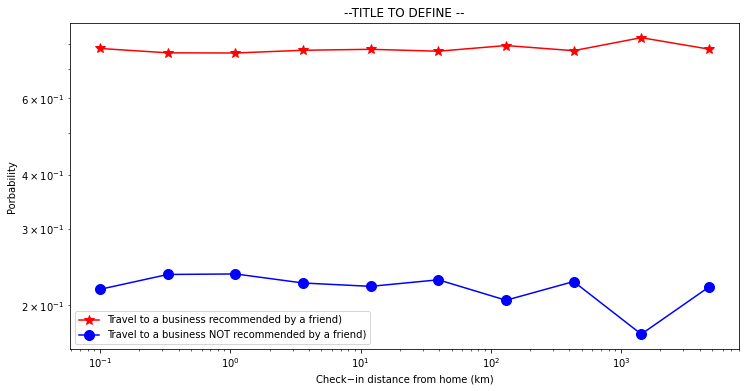

In [407]:
plt.figure(figsize=(12, 6))
# What I obtain previously, with the first P_null
#plt.subplot(121)
plt.plot(interval_dist,good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
plt.plot(interval_dist,bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Porbability")
plt.xlabel("Check−in distance from home (km)")
plt.legend(loc="lower left")
plt.title("--TITLE TO DEFINE --")

plt.show()

# Week Day Study

In [408]:
def compute_fractions_week(df,number_distance_groups):
    grouped = df.groupby(['id_groups','week_day']).count()['user_id'].reset_index()
    grouped.rename(columns = {'user_id':'counts'},inplace=True)
    dict_group_revlabel = grouped.groupby(['id_groups','week_day'])['counts'].apply(list).apply(np.squeeze).to_dict()
    
    
    mon_reviews = []
    tue_reviews = []
    wed_reviews = []
    thu_reviews = []
    fri_reviews = []
    sat_reviews = []
    sun_reviews = []
    for group_id in range(number_distance_groups):
        target_rows = np.where(df['id_groups']==group_id)[0]
        tot = float(len(target_rows))
        if(tot==0):
            good_reviews.append(0)
            bad_reviews.append(0)
        else:
            group_mon = (dict_group_revlabel.get((group_id,0))or 0)
            group_tue = (dict_group_revlabel.get((group_id,1))or 0)
            group_wed = (dict_group_revlabel.get((group_id,2))or 0)
            group_thu = (dict_group_revlabel.get((group_id,3))or 0)
            group_fri = (dict_group_revlabel.get((group_id,4))or 0)
            group_sat = (dict_group_revlabel.get((group_id,5))or 0)
            group_sun = (dict_group_revlabel.get((group_id,6))or 0)
                  
            mon_reviews.append(group_mon/tot) 
            tue_reviews.append(group_tue/tot)
            wed_reviews.append(group_wed/tot)
            thu_reviews.append(group_thu/tot)
            fri_reviews.append(group_fri/tot)
            sat_reviews.append(group_sat/tot)
            sun_reviews.append(group_sun/tot)
    return mon_reviews,tue_reviews,wed_reviews,thu_reviews,fri_reviews,sat_reviews,sun_reviews

In [409]:
mon_reviews,tue_reviews,wed_reviews,thu_reviews,fri_reviews,sat_reviews,sun_reviews = compute_fractions_week(df_selectedReviews_v2,number_distance_groups)

In [410]:
mon_reviews

[0.14969208905731882,
 0.1619061713778304,
 0.16002461538461538,
 0.15791365757014125,
 0.157122782893983,
 0.16099765537395086,
 0.16659672681493914,
 0.16655618163738814,
 0.16237716424894713,
 0.15500710227272727]

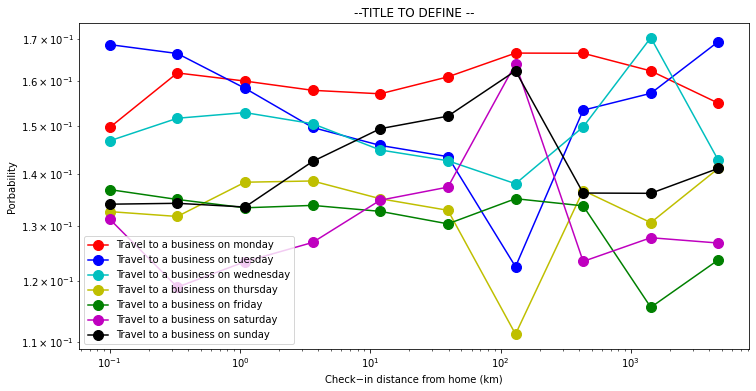

In [411]:
plt.figure(figsize=(12, 6))
# What I obtain previously, with the first P_null
#plt.subplot(121)
plt.plot(interval_dist,mon_reviews,'ro-', markersize=10,label='Travel to a business on monday')
plt.plot(interval_dist,tue_reviews,'bo-', markersize=10,label='Travel to a business on tuesday')
plt.plot(interval_dist,wed_reviews,'co-', markersize=10,label='Travel to a business on wednesday')
plt.plot(interval_dist,thu_reviews,'yo-', markersize=10,label='Travel to a business on thursday')
plt.plot(interval_dist,fri_reviews,'go-', markersize=10,label='Travel to a business on friday')
plt.plot(interval_dist,sat_reviews,'mo-', markersize=10,label='Travel to a business on saturday')
plt.plot(interval_dist,sun_reviews,'ko-', markersize=10,label='Travel to a business on sunday')
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Porbability")
plt.xlabel("Check−in distance from home (km)")
plt.legend(loc="lower left")
plt.title("--TITLE TO DEFINE --")

plt.show()

# Variant

In [412]:
mon_checkins = df_selectedReviews_v2[df_selectedReviews_v2["week_day"] == 0]
tue_checkins = df_selectedReviews_v2[df_selectedReviews_v2["week_day"] == 1]
wed_checkins = df_selectedReviews_v2[df_selectedReviews_v2["week_day"] == 2]
thu_checkins = df_selectedReviews_v2[df_selectedReviews_v2["week_day"] == 3]
fri_checkins = df_selectedReviews_v2[df_selectedReviews_v2["week_day"] == 4]
sat_checkins = df_selectedReviews_v2[df_selectedReviews_v2["week_day"] == 5]
sun_checkins = df_selectedReviews_v2[df_selectedReviews_v2["week_day"] == 6]

In [413]:
mon_good_reviews,mon_bad_reviews = compute_fractions(mon_checkins,number_distance_groups)
tue_good_reviews,tue_bad_reviews = compute_fractions(tue_checkins,number_distance_groups)
wed_good_reviews,wed_bad_reviews = compute_fractions(wed_checkins,number_distance_groups)
thu_good_reviews,thu_bad_reviews = compute_fractions(thu_checkins,number_distance_groups)
fri_good_reviews,fri_bad_reviews = compute_fractions(fri_checkins,number_distance_groups)
sat_good_reviews,sat_bad_reviews = compute_fractions(sat_checkins,number_distance_groups)
sun_good_reviews,sun_bad_reviews = compute_fractions(sun_checkins,number_distance_groups)

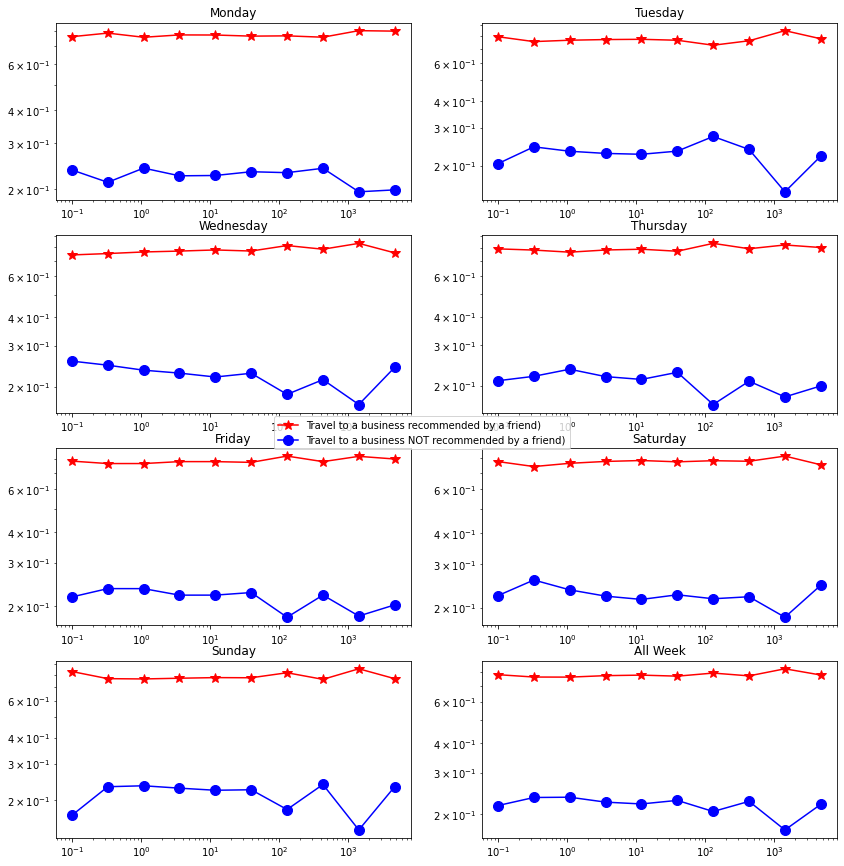

In [414]:
f, ax = plt.subplots(4, 2, figsize=(14, 15))
ax[0,0].plot(interval_dist,mon_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[0,0].plot(interval_dist,mon_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_title("Monday")

ax[0,1].plot(interval_dist,tue_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[0,1].plot(interval_dist,tue_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_title("Tuesday")

ax[1,0].plot(interval_dist,wed_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[1,0].plot(interval_dist,wed_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_title("Wednesday")

ax[1,1].plot(interval_dist,thu_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[1,1].plot(interval_dist,thu_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_title("Thursday")

ax[2,0].plot(interval_dist,fri_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[2,0].plot(interval_dist,fri_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[2,0].set_xscale('log')
ax[2,0].set_yscale('log')
ax[2,0].set_title("Friday")

ax[2,1].plot(interval_dist,sat_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[2,1].plot(interval_dist,sat_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[2,1].set_xscale('log')
ax[2,1].set_yscale('log')
ax[2,1].set_title("Saturday")

ax[3,0].plot(interval_dist,sun_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[3,0].plot(interval_dist,sun_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[3,0].set_xscale('log')
ax[3,0].set_yscale('log')
ax[3,0].set_title("Sunday")

ax[3,1].plot(interval_dist,good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[3,1].plot(interval_dist,bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[3,1].set_xscale('log')
ax[3,1].set_yscale('log')
ax[3,1].set_title("All Week")


handles, labels = ax[0,0].get_legend_handles_labels()
f.legend(handles, labels, loc='center')

# Categories

In [312]:
# Read original dataframe
df_business_ori = pd.read_json("./data/yelp_academic_dataset_business.json", lines = True)

In [313]:
df_business_ori

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209388,9Q0fPWAjUweoFDk0kafuzQ,Nishi Sushi,9750 Weston Road,Vaughan,ON,L4H 2P2,43.838555,-79.559823,4.0,5,0,"{'Ambience': '{'romantic': False, 'intimate': ...","Japanese, Sushi Bars, Restaurants","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
209389,PotiAhtDMYMNsJCzV0oLAw,Walmart,3240 Wilkinson Blvd,Charlotte,NC,28208,35.226307,-80.893539,2.0,13,0,"{'RestaurantsPriceRange2': '1', 'BusinessParki...","Department Stores, Food, Mobile Phones, Fashio...",None
209390,SYa2j1boLF8DcGVOYfHPcA,Five Guys,7014-590 E Camelback Rd,Scottsdale,AZ,85251,33.504062,-111.929431,3.5,97,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","American (New), Food, Burgers, Restaurants, Fa...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
209391,RSSIsgO00OuWQTRoITacpA,Indian Trail Dog Training,,Indian Trail,NC,28079,35.101965,-80.599385,5.0,3,1,None,"Pet Services, Pet Training, Pets","{'Monday': '0:0-0:0', 'Tuesday': '7:0-19:0', '..."


In [318]:
# Keep only relevant colunms
df_business = df_business_ori[['business_id','state','latitude','longitude', 'categories','stars']].copy()
# Show an example
df_business["categories"]

'Active Life, Gun/Rifle Ranges, Guns & Ammo, Shopping'

In [329]:
df_business['categories'] = df_business.categories.apply(lambda x: [] if x == None else x.split(', '))
df_business

,business_id,state,latitude,longitude,categories,stars
0,f9NumwFMBDn751xgFiRbNA,NC,35.462724,-80.852612,"[Active Life, Gun/Rifle Ranges, Guns & Ammo, S...",3.5
1,Yzvjg0SayhoZgCljUJRF9Q,AZ,33.569404,-111.890264,"[Health & Medical, Fitness & Instruction, Yoga...",5.0
2,XNoUzKckATkOD1hP6vghZg,QC,45.479984,-73.580070,"[Pets, Pet Services, Pet Groomers]",5.0
3,6OAZjbxqM5ol29BuHsil3w,NV,36.219728,-115.127725,"[Hardware Stores, Home Services, Building Supp...",2.5
4,51M2Kk903DFYI6gnB5I6SQ,AZ,33.428065,-111.726648,"[Home Services, Plumbing, Electricians, Handym...",4.5
...,...,...,...,...,...,...
209388,9Q0fPWAjUweoFDk0kafuzQ,ON,43.838555,-79.559823,"[Japanese, Sushi Bars, Restaurants]",4.0
209389,PotiAhtDMYMNsJCzV0oLAw,NC,35.226307,-80.893539,"[Department Stores, Food, Mobile Phones, Fashi...",2.0
209390,SYa2j1boLF8DcGVOYfHPcA,AZ,33.504062,-111.929431,"[American (New), Food, Burgers, Restaurants, F...",3.5
209391,RSSIsgO00OuWQTRoITacpA,NC,35.101965,-80.599385,"[Pet Services, Pet Training, Pets]",5.0


In [79]:
df_categories = pd.read_csv('name_category.csv')

In [86]:
indexCategory = {val: key for key, val in enumerate(set(df_categories['category']))}

In [91]:
dict_categories = df_categories.set_index('name')['category'].to_dict()

In [92]:
numberCat = len(set(df_categories['category']))
def create_category_mask(row): 
    res  = np.zeros(numberCat)
    for r in row:
        category = dict_categories.get(r)
        index = indexCategory.get(category)
        res[index] = 1
    return res > 0

In [93]:
categoryMask = df_business.apply(lambda x: create_category_mask(x.categories),axis=1)

In [95]:
for category_name in set(df_categories['category']):
    df_business[category_name] = [tup[indexCategory.get(category_name)] for tup in categoryMask]

In [100]:
df_business.sample(3)

,business_id,state,latitude,longitude,categories,stars,Automotive,Construction,Manufacturing,Legal,...,Travel,Entertainment,RealEstate,Merchant,Computers,Sport,Health,BusinessSupport,Home,Miscellaneous
56881,VeYLpoglt8XepYdN2PjSmA,ON,43.672085,-79.322086,"[Chinese, Restaurants, Hakka]",3.5,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
118488,YB5bR4QQ4mkFPxZwbTpa_Q,OH,41.359070,-81.390683,"[Nurseries & Gardening, Home & Garden, Shoppin...",3.0,False,False,False,False,...,False,False,False,True,True,False,False,True,True,False
199619,Xf_FTNgrLRWIiVMHJ_rYpA,AZ,33.741508,-111.979869,"[Health & Medical, Doctors]",2.5,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [105]:
df_selectedReviews_cat = pd.merge(df_selectedReviews, df_business[["business_id"]+list(set(df_categories['category']))], left_on='business_id', right_on='business_id', how='inner')

In [106]:
df_selectedReviews_cat.sample(3)

,review_id,user_id,business_id,stars_x,date,latitude,longitude,stars_y,reviewed_by_friend_before,reviewed_before_friend_4,...,Travel,Entertainment,RealEstate,Merchant,Computers,Sport,Health,BusinessSupport,Home,Miscellaneous
1662880,Shz_GRs8v7bqmkgbMDXOlw,pspJkQgUOap1OjTZVMbdsQ,1ofeAP5vdjnOSeO5S2pzSg,4,2018-04-15 05:39:31,40.451404,-80.162472,2.5,-1,0,...,False,False,False,False,False,False,False,False,False,False
2026967,fBaEr-uqxy7576auxVCuOg,-s_3V_7IrkVBcsi-gWxKog,vC23Fq8lMkNiZ4F8yh3ukQ,4,2017-06-30 00:51:03,33.456419,-112.070371,3.5,5,2,...,False,False,False,False,False,False,False,True,False,False
2499029,t7mVa8T9W7eMFDzcRxzGfQ,03nkVeDCMtei1Xjk6ZVjQA,FFCzkdXM1AbMTuckTrzf-Q,5,2013-10-04 16:30:40,36.118019,-115.174661,4.5,-1,0,...,False,True,False,False,False,False,False,False,False,False


In [157]:
df_selectedReviews_catv2 = df_selectedReviews_cat[df_selectedReviews_cat["reviewed_before_friend_4"] !=0]

In [158]:
check_in_per_category_v2 = []
for cat in set(df_categories['category']):
    check_in_per_category_v2.append(df_selectedReviews_catv2[df_selectedReviews_catv2[cat] == True].drop(list(set(df_categories['category'])),axis = 1))

In [164]:
good_bad_reviews_cat_v2 = []
for df in check_in_per_category:
    good_bad_reviews_cat_v2.append(compute_fractions(df,number_distance_groups))
good_bad_reviews_cat_v2.append(compute_fractions(df_selectedReviews_catv2,number_distance_groups))

Text(0.5, 1.0, 'All cat')

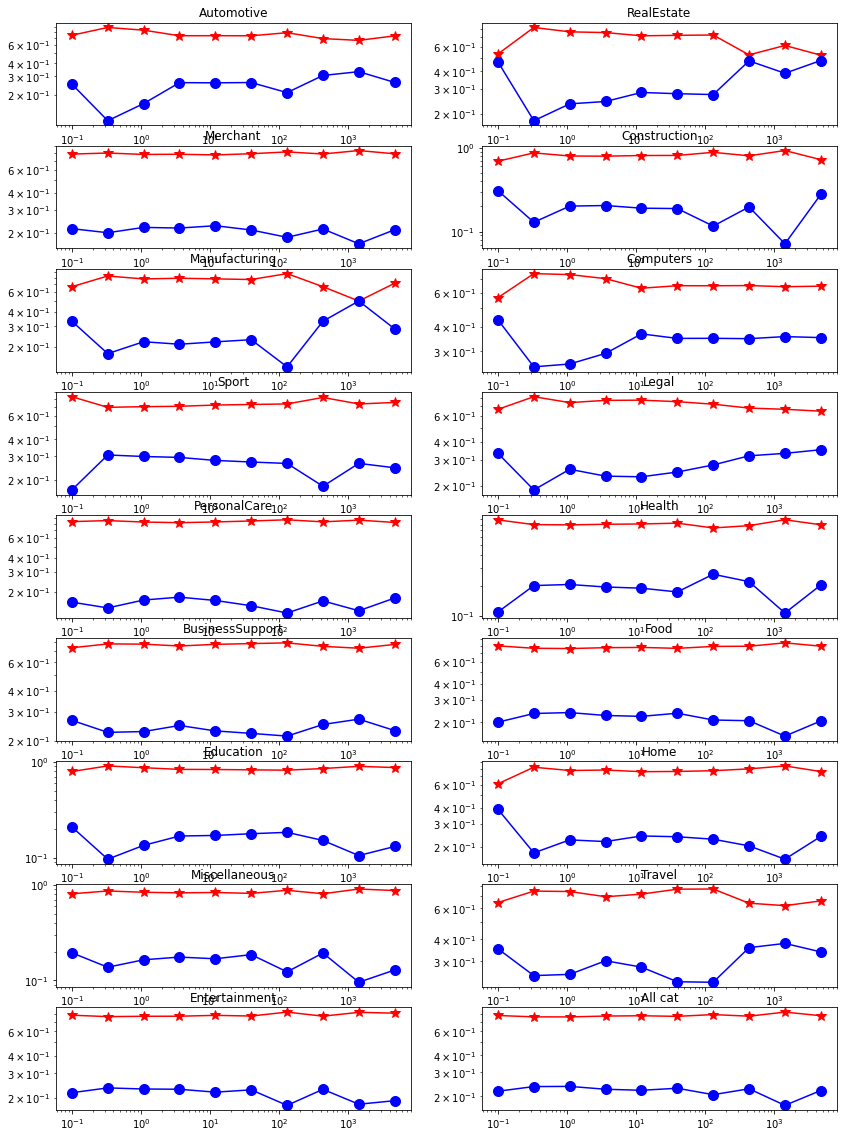

In [165]:
f, ax = plt.subplots(9, 2, figsize=(14, 20))
i = 0
for cat in set(df_categories['category']):
    ix = i%9
    iy = i%2
    ax[ix,iy].plot(interval_dist,good_bad_reviews_cat_v2[i][0],'r*-', markersize=10,label='Travel to a business recommended by a friend)')
    ax[ix,iy].plot(interval_dist,good_bad_reviews_cat_v2[i][1],'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
    ax[ix,iy].set_xscale('log')
    ax[ix,iy].set_yscale('log')
    ax[ix,iy].set_title(cat)
    i += 1

ax[8,1].plot(interval_dist,good_bad_reviews_cat_v2[i][0],'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[8,1].plot(interval_dist,good_bad_reviews_cat_v2[i][1],'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[8,1].set_xscale('log')
ax[8,1].set_yscale('log')
ax[8,1].set_title('All cat')

In [166]:
check_in_per_category_v1 = []
for cat in set(df_categories['category']):
    check_in_per_category_v1.append(df_selectedReviews_cat[df_selectedReviews_cat[cat] == True].drop(list(set(df_categories['category'])),axis = 1))

In [167]:
good_bad_reviews_cat_v1 = []
for df in check_in_per_category_v1:
    good_bad_reviews_cat_v1.append(compute_fractions(df,number_distance_groups))
good_bad_reviews_cat_v1.append(compute_fractions(df_selectedReviews_cat,number_distance_groups))

Text(0.5, 1.0, 'All cat')

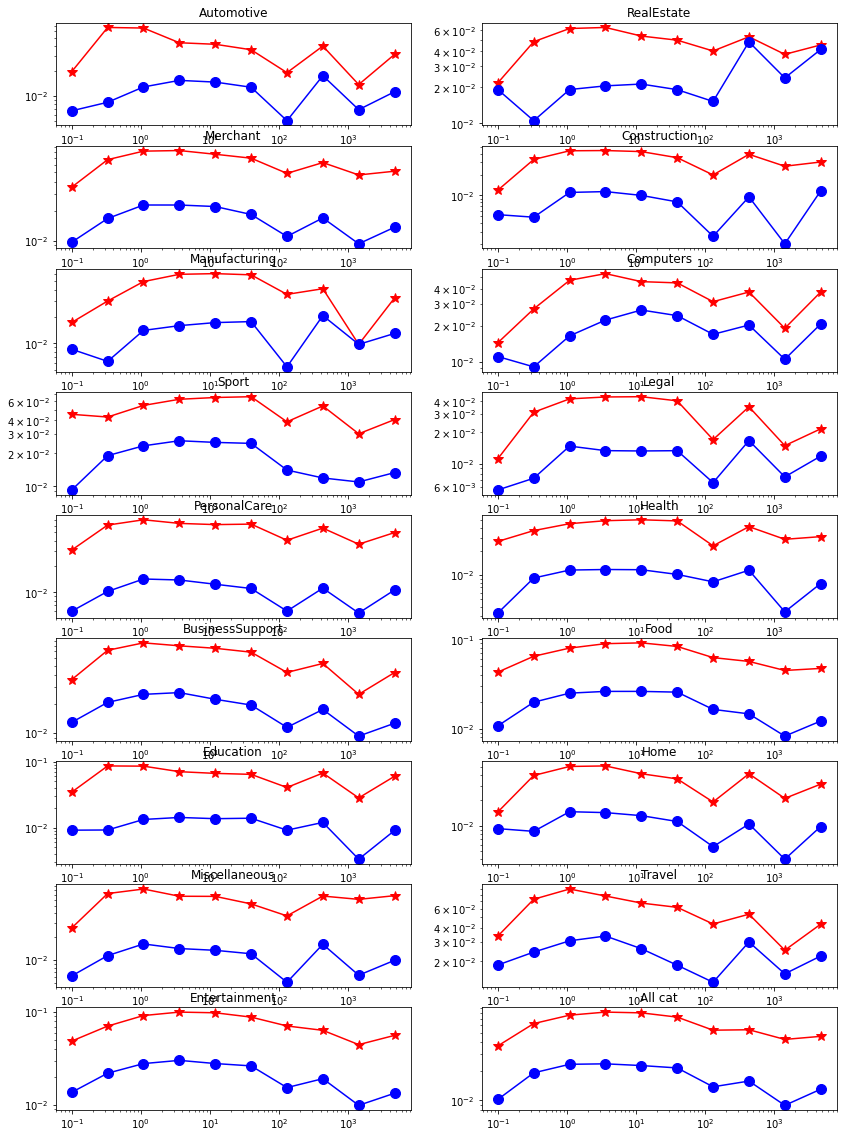

In [168]:
f, ax = plt.subplots(9, 2, figsize=(14, 20))
i = 0
for cat in set(df_categories['category']):
    ix = i%9
    iy = i%2
    ax[ix,iy].plot(interval_dist,good_bad_reviews_cat_v1[i][0],'r*-', markersize=10,label='Travel to a business recommended by a friend)')
    ax[ix,iy].plot(interval_dist,good_bad_reviews_cat_v1[i][1],'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
    ax[ix,iy].set_xscale('log')
    ax[ix,iy].set_yscale('log')
    ax[ix,iy].set_title(cat)
    i += 1

ax[8,1].plot(interval_dist,good_bad_reviews_cat_v1[i][0],'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[8,1].plot(interval_dist,good_bad_reviews_cat_v1[i][1],'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[8,1].set_xscale('log')
ax[8,1].set_yscale('log')
ax[8,1].set_title('All cat')

# Combining categories